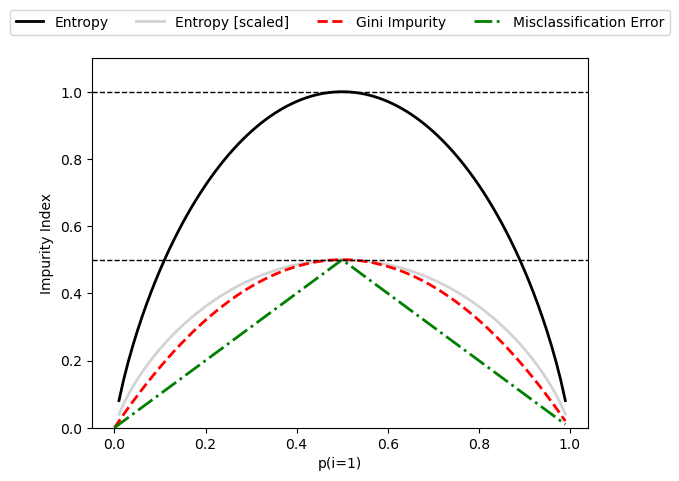

In [1]:
# graph for 3 impurity functions
# suppose only 2 classifications

import matplotlib.pyplot as plt 
import numpy as np

def gini(p):
    return 1 - p * p - (1-p) * (1-p)
def entropy(p):
    return -p * np.log2(p) - (1-p) * np.log2(1-p)
def error(p):
    return 1 - np.max([p, 1-p])
x = np.arange(0, 1, 0.01)
ent = [entropy(p) if p!=0 else None for p in x]
scale_ent = [en * 0.5 if en else None for en in ent]
err = [error(p) for p in x]
fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c in zip([ent, scale_ent, gini(x), err],
                         ['Entropy', 'Entropy [scaled]', 
                          'Gini Impurity', 'Misclassification Error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray',
                           'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=5, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.show()

In [2]:
# this cell contains all common preprocessing work

# load in data
from sklearn import datasets

df = datasets.load_iris()

X = df.data[:, [2,3]]
y = df.target

# automatically split datasets into training data and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)   # 30% testing data
# note that data would be shuffled, thus random

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X_train)
X_train_std = ss.transform(X_train)
X_test_std = ss.transform(X_test)


# define plot_decision_regions function again
# 只是画图，下次没必要自己打
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np 

def plot_decision_regions(X, y, classifier, test_idx=None,
                          resolution=0.2):
    
    # set up markers
    markers = ['s', 'x', 'o', '^', 'v']
    colors = ['red', 'blue', 'lightgreen', 'gray', 'cyan']
    # set valid colors based on y
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 0].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl,
                    edgecolor='black')
        # select the 0 and 1 column of samples where y=cl
    
    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='none', edgecolors='black', alpha=1.0,
                    linewidths=1, marker='o',
                    s=100, label='test set')

/var/folders/84/kh2lnvxd5cx0_6s9tdvbhyd00000gn/T/ipykernel_23183/3201803622.py:52: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1],


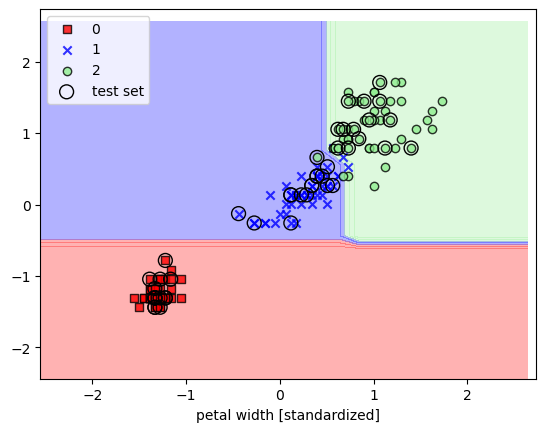

In [3]:
# build a decision tree
from sklearn.tree import DecisionTreeClassifier as DTC
tree = DTC(criterion='gini',
           max_depth=4,
           random_state=1)
tree.fit(X_train_std, y_train)
X_combined = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined,
                      y_combined,
                      classifier=tree,
                      test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.xlabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()

In [4]:
# use pydotplus package to visualize the tree

# pip3 install pydotplus
# brew install graphviz

# have not succeeded to construct env

from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
dot_data = export_graphviz(tree,
                           filled=True,
                           rounded=True,
                           class_names=['Setosa',
                                        'Versicolor',
                                        'Virginaca'],
                            feature_names=['petal length [standardized]',
                                            'petal width [standardized]'],
                            out_file=None)
graph = graph_from_dot_data(dot_data)
graph.write_png('tree.png')

InvocationException: GraphViz's executables not found

/var/folders/84/kh2lnvxd5cx0_6s9tdvbhyd00000gn/T/ipykernel_23183/3201803622.py:52: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1],


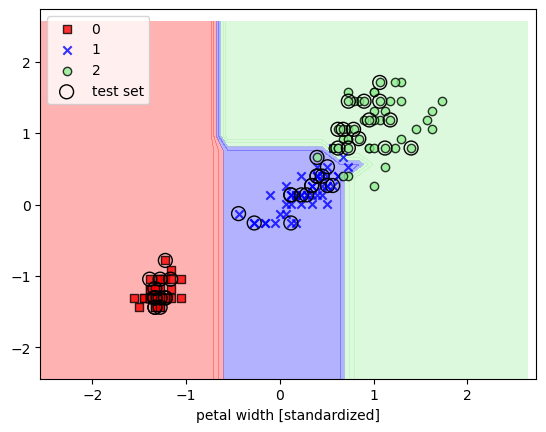

In [5]:
# combine multiple decision trees viai random forests

# parameters:
# n -- bootstrap (numbers from the training set with replacement 有重复随机取样)
# d -- number of features (default by root(total number of features))

from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25,
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train_std, y_train)
plot_decision_regions(X_combined,
                      y_combined,
                      classifier=forest,
                      test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.xlabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()